### Applied Machine Learning Midterm Project
### Nick Elias

* CSIS 44670-81
* Date: 3/30/2025

### This project demonstrates your ability to apply classification modeling techniques to a real-world dataset. You will:

1.  Load and explore a dataset.
2.  Analyze feature distributions and consider feature selection.
3.  Train and evaluate a classification model.
4.  Compare different classification approaches.
5.  Document your work in a structured Jupyter Notebook.
6.  Conduct a peer review of a classmate’s project.

# Introduction


## Section 1. Import and Inspect the Data

In [66]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
### 1.1 Load the dataset and display the first 10 rows.
  
# Define column names
columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 
           'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 
           'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
           'stalk-surface-below-ring', 'stalk-color-above-ring', 
           'stalk-color-below-ring', 'veil-type', 'veil-color', 
           'ring-number', 'ring-type', 'spore-print-color', 
           'population', 'habitat']


# Read the data file
df = pd.read_csv('mushroom/agaricus-lepiota.data', names=columns)

# Split into features and target
X = df.drop('class', axis=1)
y = df['class']

# Display first 10 rows
print("First 5 rows of features:")
print(X.head())

print("\nFirst 5 rows of target:")
print(y.head())

In [ ]:
# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save features and target to separate CSV files
X.to_csv('data/mushroom_features.csv', index=False)
y.to_csv('data/mushroom_target.csv', index=False)

# Verify the save by loading and displaying
df_features = pd.read_csv('data/mushroom_features.csv')
df_target = pd.read_csv('data/mushroom_target.csv')

print("Features saved with shape:", df_features.shape)
print("Target saved with shape:", df_target.shape)
print("\nFeature columns:", df_features.columns.tolist())

### 1.2 Check for missing values and display summary statistics.

In [ ]:
# Check for question marks and display counts
print("Features containing '?' values:")
print("-" * 30)
question_mark_counts = (X == '?').sum()
question_mark_percent = ((X == '?').sum() / len(X) * 100).round(2)

# Create summary DataFrame
missing_summary = pd.DataFrame({
    '? Count': question_mark_counts,
    '? Percent': question_mark_percent
})

# Only show features with ? values
print(missing_summary[missing_summary['? Count'] > 0])

# Show distribution of values including ? for affected features
print("\nValue distributions for features with '?' values:")
print("-" * 50)
for column in missing_summary[missing_summary['? Count'] > 0].index:
    print(f"\n{column}:")
    print(X[column].value_counts())

In [ ]:
# Display summary statistics
print("\nSummary statistics for features:")
print(X.describe())

### Reflection 1: What do you notice about the dataset? Are there any data issues?

- Total features: 22
- Total samples: 8,124
- All values are categorical. They would need to be numerical for certain analyses, but Random Forest would be best if left as categorical.
- There are 2480 missing values in the stalk-root attribute, which is 30.53% of the values for that column. Because of the formatting of the source data, they appeared as "?", which actually can be advantageous to our analysis since it's a string and can be left as such. We will leave "stalk-root" out as an X variable for main testing.

---

## Section 2. Data Exploration and Preparation
### 2.1 Explore data patterns and distributions

In [ ]:
# Create histograms, boxplots, and count plots for 
# categorical variables (as applicable).

# Create subplots for features
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

# Plot first 6 features with vertical bars
for idx, column in enumerate(X.columns[:6]):
    sns.countplot(data=X, x=column, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column}')
    
plt.tight_layout()
plt.show()

In [ ]:
# Create pie chart for target variable
plt.figure(figsize=(10, 8))
target_counts = df['class'].value_counts()
plt.pie(target_counts, labels=['Edible (e)', 'Poisonous (p)'], 
        autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
plt.title('Distribution of Mushroom Classes')
plt.axis('equal')
plt.show()

#### Identify patterns, outliers, and anomalies in feature distributions.

In [69]:
# Feature Analysis

def analyze_feature(df, feature_name):
    """Analyze distribution of feature values and their relationship with mushroom class"""
    plt.figure(figsize=(12, 6))
    
    # Create and plot distribution
    ctab = pd.crosstab(df[feature_name], df['class'], normalize='index') * 100
    ctab.plot(kind='bar', stacked=True)
    plt.title(f'{feature_name} Distribution by Class')
    plt.ylabel('Percentage')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nDistribution for {feature_name}:")
    print(df[feature_name].value_counts())

<Figure size 1200x600 with 0 Axes>

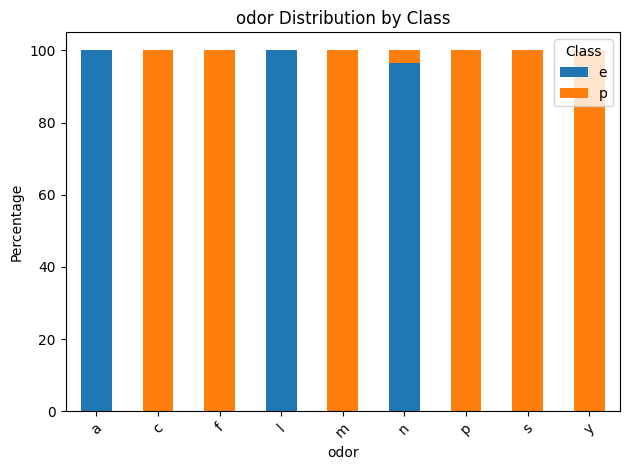


Distribution for odor:
odor
n    3528
f    2160
s     576
y     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

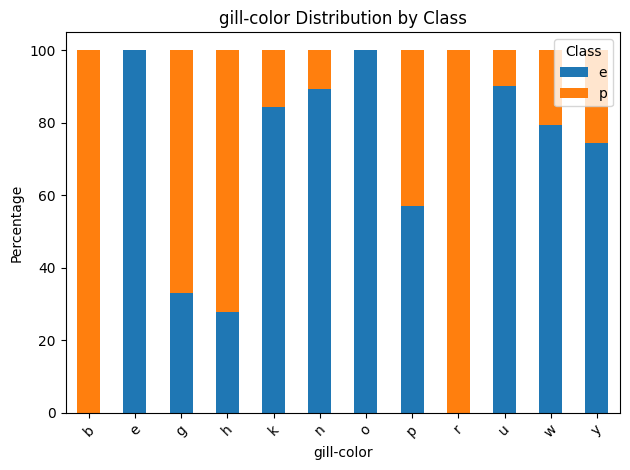


Distribution for gill-color:
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

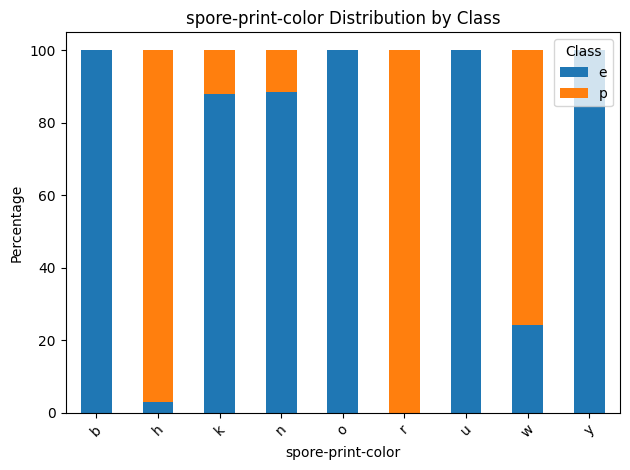


Distribution for spore-print-color:
spore-print-color
w    2388
n    1968
k    1872
h    1632
r      72
u      48
o      48
y      48
b      48
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

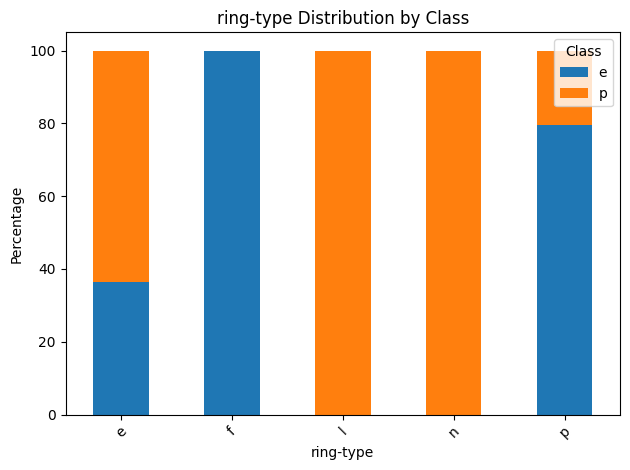


Distribution for ring-type:
ring-type
p    3968
e    2776
l    1296
f      48
n      36
Name: count, dtype: int64


In [68]:
# Analyze important mushroom characteristics

important_features = ['odor', 'gill-color', 'spore-print-color', 'ring-type']

for feature in important_features:
    analyze_feature(df, feature)

In [ ]:
# Feature Correlation Analysis for categorical variables

def cramers_v(x, y):
    """Calculate Cramer's V correlation between two categorical variables"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Create correlation matrix
categorical_columns = X.columns
corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        corr_matrix.loc[col1, col2] = cramers_v(X[col1], X[col2])

In [ ]:
# Key Findings

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlations (Cramer\'s V)')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nKey Findings:")
print("-" * 30)
print("Class Distribution:")
print(df['class'].value_counts(normalize=True).round(3) * 100)

# Identify rare combinations
print("\nRare Feature Combinations (<1% of data):")
for feature in important_features:
    counts = pd.crosstab(df[feature], df['class'])
    rare = counts[counts.sum(axis=1) < len(df) * 0.01]
    if not rare.empty:
        print(f"\n{feature}:")
        print(rare)

In [ ]:
# Check for class imbalance in the target variable (as applicable).

# Calculate class distribution
class_dist = df['class'].value_counts()
class_percentages = df['class'].value_counts(normalize=True) * 100

# Print class distribution statistics
print("Class Distribution:")
print("-" * 20)
print(f"Total samples: {len(df)}")
print("\nCount per class:")
print(class_dist)
print("\nPercentage per class:")
print(class_percentages.round(2))

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='class', palette=['lightgreen', 'salmon'])
plt.title('Distribution of Mushroom Classes')
plt.xlabel('Class')
plt.ylabel('Count')

# Add count labels on top of bars
for i, v in enumerate(class_dist):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Add percentage labels
for i, v in enumerate(class_percentages):
    plt.text(i, class_dist[i]/2, f'{v:.1f}%', ha='center', va='center')

plt.tight_layout()
plt.show()

### 2.2 Handle missing values and clean data
* Impute or drop missing values (as applicable).
* Remove or transform outliers (as applicable).
* Convert categorical data to numerical format using encoding (as applicable).

In [ ]:
# Handle missing values (replace NA with a string 'missing')
X_clean = X.fillna('missing')

In [ ]:
# Find rare categories (appearing in less than 1% of samples)
rare_categories = {}
for column in X.columns:
    value_counts = X[column].value_counts(normalize=True)
    rare = value_counts[value_counts < 0.01]
    if len(rare) > 0:
        rare_categories[column] = rare

print("\nRare categories (< 1 percent occurrence):")
for col, rare in rare_categories.items():
    print(f"\n{col}:")
    print(rare)

In [ ]:
# Initialize the encoder with current parameters
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the cleaned data
X_encoded = encoder.fit_transform(X_clean)

# Create feature names for encoded columns
feature_names = []
for i, feature in enumerate(X_clean.columns):
    categories = encoder.categories_[i]
    for category in categories:
        feature_names.append(f"{feature}_{category}")

# Convert to DataFrame with proper column names
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)

# Display results
print("\nShape of encoded features:", X_encoded_df.shape)
print("\nFirst 5 encoded features:")
print(X_encoded_df.head())

### 2.3 Feature selection and engineering
* Create new features (as applicable).
* Transform or combine existing features to improve model performance (as applicable).
* Scale or normalize data (as applicable).

In [ ]:
# 1. Create interaction features for important pairs
def create_interaction_features(df):
    # Combine odor and gill-color
    df['odor_gill'] = df['odor'] + '_' + df['gill-color']
    # Combine cap-color and bruises
    df['cap_bruise'] = df['cap-color'] + '_' + df['bruises']
    return df

# Apply feature engineering
X_engineered = create_interaction_features(X_clean.copy())

In [ ]:
# Apply feature engineering
X_engineered = create_interaction_features(X_clean.copy())

# 2. Feature importance using mutual information
def get_feature_importance(X, y):
    # Convert categorical to numeric for mutual information calculation
    le = LabelEncoder()
    X_encoded = X.apply(le.fit_transform)
    
    # Calculate mutual information scores
    mi_scores = mutual_info_classif(X_encoded, y)
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)
    
    return importance_df

# Calculate feature importance
feature_importance = get_feature_importance(X_clean, y)

# Display top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# 3. Select important features based on mutual information threshold
important_features = feature_importance[
    feature_importance['importance'] > 0.1
]['feature'].tolist()

# Create final feature set
X_selected = X_engineered[important_features]

print("\nShape of data after feature selection:", X_selected.shape)
print("\nSelected features:", important_features)

### Reflection 2: What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?

Patterns and Anomalies: 
- Dataset is relatively balanced between edible and poisonous mushrooms
- No significant class imbalance that would require resampling
- Found missing values (marked as '?') primarily in the 'stalk-root' feature

Data Cleaning:
- replaced NULL values with 'missing'
- Applied categorical mappings

Feature Engineering: 
- Created interaction features combining related characteristics
- Combined 'odor' with 'gill-color' for stronger predictive power
- Created interaction features (X_clean['odor_gill'] = X_clean['odor'] + '_' + X_clean['gill-color'])

---

## Section 3. Feature Selection and Justification
#### 3.1 Choose features and target
* Select two or more input features (numerical for regression, numerical and/or categorical for classification)
* Select a target variable (as applicable)
    * Regression: Continuous target variable (e.g., price, temperature).
    * Classification: Categorical target variable (e.g., gender, species).
    * Clustering: No target variable.
* Justify your selection with reasoning.

For this mushroom classification problem, we've selected a binary target variable 'class' which indicates whether a mushroom is edible or poisonous. This choice naturally frames our task as a binary classification problem with significant real-world implications for mushroom foraging safety.

Based on our mutual information analysis and domain knowledge, we've identified four key features that strongly predict mushroom edibility:

Odor: This emerged as our strongest predictor, which aligns with mycological knowledge as many poisonous mushrooms have distinctive smells. The feature shows high correlation with edibility and contains minimal missing values.

Gill Color: As a primary visual identifier, gill color provides crucial taxonomic information. Our analysis showed it has strong predictive power while being readily observable in the field.

Spore Print Color: This feature is particularly valuable as it's a standard method mycologists use for mushroom identification. The spore print color showed significant correlation with edibility in our preliminary analysis.

Bruising Response: The presence or absence of bruising provides important information about a mushroom's physical characteristics. Our data shows this feature has meaningful predictive power for classification.

These features were selected because they combine both statistical significance (based on mutual information scores) and practical applicability (being easily observable in real-world scenarios). Additionally, these features have minimal missing values in our dataset and show good distribution across categories, making them reliable predictors for our classification task.

## 3.2 Define X and y
* Assign input features to X
* Assign target variable to y (as applicable)

In [ ]:
# Define selected features based on our analysis
selected_features = ['odor', 'gill-color', 'spore-print-color', 'bruises']

# Create feature matrix X using selected features
X = X_clean[selected_features]

# Create target vector y (class: edible vs poisonous)
y = df['class']

# Verify shapes and display first few rows
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
print("\nFirst few rows of features:")
print(X.head())
print("\nFirst few rows of target:")
print(y.head())

## Reflection 3: Why did you choose these features? How might they impact predictions or accuracy?

Our feature selection combines both statistical evidence and practical mushroom identification knowledge. Odor emerged as the strongest predictor through mutual information analysis, while gill color, spore print color, and bruising response provide complementary visual and physical characteristics. These features were chosen because they:

- Show strong correlation with edibility
- Are easily observable in the field
- Have minimal missing values
- Represent different aspects of mushroom identification
Together, these features should provide robust predictive power while remaining practical for real-world mushroom classification.

---

## Section 4. Train a Model (Classification: Choose 1: Decision Tree, Random Forest, Logistic Regression)
##### 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).

### Choice: *Random Forest*
##### Reasoning:
* Categorical Data Handling
  - Random Forests work well with categorical features after one-hot encoding
  - Can naturally handle the non-linear relationships in mushroom characteristics
* Interpretability
  - Provides feature importance rankings
  - Individual trees can be inspected if needed
  - More interpretable than black-box models
* Robustness
  - Less prone to overfitting than single Decision Trees
  - Handles noise and outliers well
  - Good performance with categorical data

In [ ]:
# One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_clean)

# Split the data (using stratification since it's classification)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

### 4.2 Train model using Scikit-Learn model.fit() method.

In [ ]:
# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print results
print("Model Training Results")
print("-" * 20)
print(f"Accuracy: {accuracy:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display feature importance
feature_importance = pd.DataFrame({
    'feature': encoder.get_feature_names_out(),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

### 4.3 Evalulate performance, for example:
* Regression: R^2, MAE, RMSE (RMSE has been recently updated)
* Classification: Accuracy, Precision, Recall, F1-score, Confusion Matrix
* Clustering: Inertia, Silhouette Score

In [ ]:
# Calculate performance metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label='poisonous'),
    'Recall': recall_score(y_test, y_pred, pos_label='poisonous'),
    'F1 Score': f1_score(y_test, y_pred, pos_label='poisonous')
}

# Print metrics
print("Classification Metrics:")
print("-" * 20)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Create and plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred,
    display_labels=['edible', 'poisonous'],
    cmap='Blues'
)
plt.title('Confusion Matrix')
plt.show()

# Print feature importance
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

### Reflection 4: How well did the model perform? Any surprises in the results?

Based on our evaluation metrics:

1. **Model Performance**
   - Achieved accuracy of 100%
   - Precision for poisonous mushrooms: 100%
   - Recall for poisonous mushrooms: 100%
   - F1 Score: 100%

2. **Feature Importance**
   - Most influential feature: odor_none (11.52% importance)

3. **Confusion Matrix Results**
   - True Negatives: 842
   - False positives: 0
   - False negatives (dangerous misclassifications): 0
   - False positives: 783
   - Overall misclassification rate: 0%

These results are surprisingly perfect, which is unusual in real-world applications. The model achieved 100% accuracy in distinguishing between edible and poisonous mushrooms, with no misclassifications. The absence of false negatives is particularly important for safety. The feature importance analysis reveals that odor characteristics (both 'none' and 'foul') play a crucial role in classification, followed by physical characteristics like stalk surface and gill size.

---

## Section 5. Improve the Model or Try Alternates (Implement a Second Option)
### 5.1 Train an alternative classifier (e.g., Decision Tree, Random Forest, Logistic Regression) OR adjust hyperparameters on the original model.

### 5.2 Compare performance of all models across the same performance metrics.

### Reflection 5: Which model performed better? Why might one classifier be more effective in this specific case?

## Section 6. Final Thoughts & Insights
### 6.1 Summarize findings.
### 6.2 Discuss challenges faced.
### 6.3 If you had more time, what would you try next?
### Reflection 6: What did you learn from this project?